In [261]:
import numpy as np
import pandas as pd
import subprocess
import time
import holidays

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from matplotlib import rcParams 
from tqdm import tqdm
from datetime import datetime, date
from IPython.display import IFrame

#========================   PATHS   ========================#
TRAIN_PATH= 'data/train.csv'
TEST_PATH= 'data/test.csv'
MASK_PATH= 'https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png'
CNG_PATH= 'img/congestion_table.png' #congestion table
SAF_PATH= 'img/seasonalAdjFac.png' #seasonality adjustment factor

# Load Datasets
#### Train Dataset
    The train dataset contains over 55,423,856 rows and 7 columns, making it hard to manipulate. The following solution parts the dataset into chunks that are afterwards concatenated. Also, it includes a faster way to read date type values, than the pre-defined parse_date parameter of read_csv.
Source: [kaggle](https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows)

In [262]:
%%time

df_list = [] # list to hold the batch dataframe
chunksize = 5_000_000 # 5m rows chunks

# Columns to keep and input for dtype
traintypes = {'fare_amount': np.float32,
              'pickup_datetime': str, 
              'pickup_longitude': np.float32,
              'pickup_latitude': np.float32,
              'dropoff_longitude': np.float32,
              'dropoff_latitude': np.float32,
              'passenger_count': int}


for df_chunk in tqdm(pd.read_csv(TRAIN_PATH,
                                 nrows= 5_000_000,
                                 usecols= list(traintypes.keys()),
                                 dtype= traintypes,
                                 chunksize= chunksize)):
     
    # Faster than using parse_dates
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str[0: 13]
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'],
                                                 utc=True, 
                                                 format='%Y/%m/%d %H')
    df_list.append(df_chunk) 

        
# Merge all dataframes into one dataframe
train = pd.concat(df_list)

# Delete the dataframe list to release memory
del df_list



1it [00:13, 13.42s/it]

CPU times: user 11.7 s, sys: 1.68 s, total: 13.4 s
Wall time: 13.5 s


In [263]:
train.head()

fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0          4.5 2009-06-15 17:00:00+00:00        -73.844315        40.721317   
1         16.9 2010-01-05 16:00:00+00:00        -74.016045        40.711304   
2          5.7 2011-08-18 00:00:00+00:00        -73.982735        40.761269   
3          7.7 2012-04-21 04:00:00+00:00        -73.987129        40.733143   
4          5.3 2010-03-09 07:00:00+00:00        -73.968094        40.768009   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.841614         40.712276                1  
1         -73.979271         40.782005                1  
2         -73.991241         40.750561                2  
3         -73.991570         40.758091                1  
4         -73.956657         40.783764                1

#### Load Test Datset

In [264]:
test = pd.read_csv(TEST_PATH, usecols=[1,2,3,4,5,6], header= 0)
test.head()

pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-01-27 13:08:24 UTC        -73.973320        40.763805   
1  2015-01-27 13:08:24 UTC        -73.986862        40.719383   
2  2011-10-08 11:53:44 UTC        -73.982524        40.751260   
3  2012-12-01 21:12:12 UTC        -73.981160        40.767807   
4  2012-12-01 21:12:12 UTC        -73.966046        40.789775   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.981430         40.743835                1  
1         -73.998886         40.739201                1  
2         -73.979654         40.746139                1  
3         -73.990448         40.751635                1  
4         -73.988565         40.744427                1

## Data Cleaning
#### Remove duplicates

In [265]:
print(f"From {train.shape[0]} rows,")
train.drop_duplicates(inplace=True)
print(f"to {train.shape[0]} rows")

From 5000000 rows,
to 4998527 rows


#### Remove Null values

In [266]:
#check for missing values
print(f"Missing values in TRAIN datset: \n{train.isnull().sum().sort_values(ascending=False)}\n")
print(f"Missing values in TEST datset: \n{test.isnull().sum().sort_values(ascending=False)}\n")

#drop the missing values
indexes = list(train.loc[train.isnull().any(1)].index)
train.drop(index= indexes, inplace= True)

Missing values in TRAIN datset: 
dropoff_latitude     36
dropoff_longitude    36
passenger_count       0
pickup_latitude       0
pickup_longitude      0
pickup_datetime       0
fare_amount           0
dtype: int64

Missing values in TEST datset: 
passenger_count      0
dropoff_latitude     0
dropoff_longitude    0
pickup_latitude      0
pickup_longitude     0
pickup_datetime      0
dtype: int64



#### Variable Fares 
    There are fares with negative or zero values. The corresponding rows are removed.

In [267]:
# Description
print(train['fare_amount'].describe())

bad_values= train.loc[train['fare_amount']<=0].index
print(f"\nRows with negative/ zero values: {len(bad_values)}")

# Remove rows
train.drop(bad_values, axis=0, inplace=True)

count    4.998491e+06
mean     1.134178e+01
std      9.820927e+00
min     -1.000000e+02
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      1.273310e+03
Name: fare_amount, dtype: float64

Rows with negative/ zero values: 343


#### Variable Passengers 
    On the train dataset, there are rides with zero or negative passengers. Also, there are rides with an excessive amount of passengers. The corresponding rows are removed.

In [268]:
print("Passengers in the test dataset:", test['passenger_count'].describe())
print("\nPassengers in the train dataset:", train['passenger_count'].describe())

# Position of rows
bad_values= list(train.loc[train['passenger_count']>12].index) + \
            list(train.loc[train['passenger_count']<=0].index)

# Deletion
train.drop(index= bad_values, inplace=True)

Passengers in the test dataset: count    9914.000000
mean        1.671273
std         1.278747
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: passenger_count, dtype: float64

Passengers in the train dataset: count    4.998148e+06
mean     1.684875e+00
std      1.331980e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.080000e+02
Name: passenger_count, dtype: float64


#### Date Variable

In [269]:
print(f"Earliest date: {train['pickup_datetime'].min()}")
print(f"Latest date: {train['pickup_datetime'].max()}")
print(f"Time Span: {train['pickup_datetime'].max() -train['pickup_datetime'].min()}")

Earliest date: 2009-01-01 00:00:00+00:00
Latest date: 2015-06-30 23:00:00+00:00
Time Span: 2371 days 23:00:00


#### Spatial Variables
   Initially, the bounds of the NYC are set, as they were drawn on the map of [boundingbox](https://boundingbox.klokantech.com/). Then, the dataset is filtered. 

In [270]:
# Boundaries of the metropolitan area
Boundaries = (-74.3, -73.6, 40.5, 41)
long_lim = list(Boundaries[0:2])
lat_lim = list(Boundaries[2:4])


# NYC Coordinates
nyc = (40.7141667, -74.0063889)
# Airports Coordinates
jfk= (40.6441666667, -73.7822222222)
lgd= (40.7769271, -73.87396590000003)



# Remove rides outside the metropolitan area
# Longitude
train = train[(train.pickup_longitude> long_lim[0]) & (train.pickup_longitude < long_lim[1])]
train = train[(train.dropoff_longitude> long_lim[0]) & (train.dropoff_longitude < long_lim[1])]
# Latitude
train = train[(train.pickup_latitude> lat_lim[0]) & (train.pickup_latitude < lat_lim[1])]
train = train[(train.dropoff_latitude> lat_lim[0]) & (train.dropoff_latitude < lat_lim[1])]

#### Mask datapoints in the water
    A number of points are located on coordinates that correspond to sea or rivers. These datapoints are detected, with a mask from a map of the area, and are deleted. Initially, the mask is transformed in order to only contain 0 and 1 values. Then, the coordinates are transformed to the local X~Y system and the mask is applied to eliminate fault datapoints.

In [271]:
# Load mask
mask = plt.imread(MASK_PATH)[:,:,0] #y first, x second

# Need to make it boolean in order to use it as mask
print("Unique values before:\n\n",np.unique(mask))

mask = mask>0.5
print("\nUnique values after:\n\n",np.unique(mask))

Unique values before:

 [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.02745098
 0.03529412 0.05490196 0.05882353 0.06666667 0.07450981 0.08235294
 0.08627451 0.09019608 0.09803922 0.12156863 0.12941177 0.14509805
 0.14901961 0.16470589 0.16862746 0.22745098 0.23921569 0.26666668
 0.27058825 0.32941177 0.33333334 0.34117648 0.37254903 0.3882353
 0.4117647  0.41568628 0.48235294 0.52156866 0.54509807 0.58431375
 0.59607846 0.627451   0.6666667  0.68235296 0.70980394 0.7137255
 0.72156864 0.73333335 0.7411765  0.7764706  0.7882353  0.8235294
 0.827451   0.85490197 0.8627451  0.88235295 0.8862745  0.9019608
 0.92156863 0.92941177 0.9411765  0.9529412  0.9607843  0.9764706
 0.98039216 1.        ]

Unique values after:

 [False  True]


In [272]:
def to_XY (longitude, latitude, mask, Boundaries):
    minLongitude = Boundaries[0]
    minLatitude = Boundaries[2]
    
    length = Boundaries[1] - minLongitude
    width = Boundaries[3] - minLatitude
    
    mask_length = mask.shape[1]
    mask_width = mask.shape[0]
    
    x = mask_length * (longitude - minLongitude) / length
    y = mask_width * (1 - (latitude - minLatitude) / width ) #imread reads from +y to -y

    
    return x.astype("int") ,y.astype("int")

#===================================================================================

# Application

pickupX, pickupY = to_XY(longitude= train.pickup_longitude, 
                         latitude= train.pickup_latitude, 
                         mask= mask,
                         Boundaries= Boundaries)

dropoffX, dropoffY = to_XY(longitude= train.dropoff_longitude, 
                         latitude= train.dropoff_latitude, 
                         mask= mask,
                         Boundaries= Boundaries)

# Multiply X,Ys with the mask
# Bitwise addition to concatenate all points into one array
idx = mask[pickupY, pickupX] & mask[dropoffY, dropoffX]
print("Number of trips in water: {}".format(np.sum(~idx)))

Number of trips in water: 52075


In [273]:
print(f"From {train.shape[0]} rows,")

# Keep only points in land
train = train[idx]

print(f"to {train.shape[0]} rows.")

From 4872759 rows,
to 4820684 rows.


## Visualise datapoints
    For a sample from the dataset the spatial points are ploted. The magnitude of the points is sufficient to view an abstract mapping of the metropolitan area. Also, it is interesting to see that the vast majority of the geospatial points are located in Manhattan

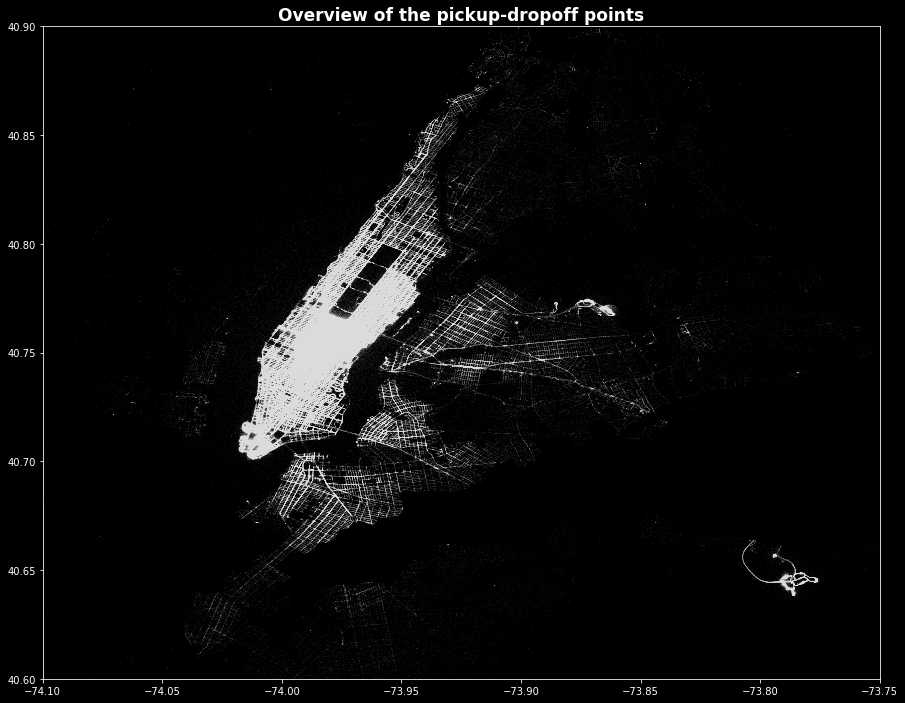

CPU times: user 7.36 s, sys: 822 ms, total: 8.19 s
Wall time: 8.41 s


In [274]:
%%time
%matplotlib inline

# Plot pickups, dropoffs
plot_df= train

a1 = list(plot_df.pickup_longitude)
a2 = list(plot_df.pickup_latitude)

b1 = list(plot_df.dropoff_longitude)
b2 = list(plot_df.dropoff_latitude)

# Plot 

plt.style.use('dark_background')
plt.figure(figsize = (15,12))

plt.plot( a1, a2 ,'.', color='white', alpha = 0.32, markersize = 0.06)
plt.plot( b1, b2 ,'.', color='white', alpha = 0.32, markersize = 0.06)
plt.title(label= "Overview of the pickup-dropoff points", fontdict= {'weight' : 'bold', 'size'   : 17})

plt.xlim((-74.1, -73.75))
plt.ylim((40.6, 40.9))
plt.show()

## temp title

In [ ]:
# Airport Coordinates

jfk_coordinates = (40.639722, -73.778889) # JFK: John F. Kennedy International Airport
ewr_coordinates = (40.6925, -74.168611)  # EWR: Newark Liberty International Airport
lga_coordinates = (40.77725, -73.872611) # LGA: LaGuardia Airport

def get_haversine_dist(start_lat, start_lon, finish_lat, finish_lon):

    r = 3956 # radius of earth in miles
    # convert latitude/longitude degrees to radians
    start_lat, start_lon, finish_lat, finish_lon = map(np.radians,
                                                             [start_lat, start_lon, 
                                                              finish_lat, finish_lon])
    #Compute distances along lat, lon dimensions
    dlat = finish_lat - start_lat
    dlon = finish_lon - start_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(start_lat) * np.cos(finish_lat) * np.sin(dlon/2.0)**2
    
    return 2 * r * np.arcsin(np.sqrt(a))

#all distance calculations

train['distance_of_ride'] = get_haversine_dist(train['pickup_latitude'], train['pickup_longitude'], 
                                   train['dropoff_latitude'] , train['dropoff_longitude'])
train['distance_pickup_jfk'] =  get_haversine_dist(train['pickup_latitude'], train['pickup_longitude'], jfk_coordinates[0], jfk_coordinates[1]) 
train['distance_dropoff_jfk'] =  get_haversine_dist(train['dropoff_latitude'], train['dropoff_longitude'], jfk_coordinates[0], jfk_coordinates[1]) 

train['distance_pickup_ewr'] =  get_haversine_dist(train['pickup_latitude'], train['pickup_longitude'], ewr_coordinates[0], ewr_coordinates[1]) 
train['distance_dropoff_ewr'] =  get_haversine_dist(train['dropoff_latitude'], train['dropoff_longitude'], ewr_coordinates[0], ewr_coordinates[1]) 

train['distance_pickup_lga'] =  get_haversine_dist(train['pickup_latitude'], train['pickup_longitude'], lga_coordinates[0], lga_coordinates[1]) 
train['distance_dropoff_lga'] =  get_haversine_dist(train['dropoff_latitude'], train['dropoff_longitude'], lga_coordinates[0], lga_coordinates[1])


#### Clean Data based on distance
        It appears that for many rows, the pickup point is the same as the dropoff point, while there is a fare charged and a number of passengers. We assume it corresponds to rides charging the waiting time for the taxi without an actual route. Therefore, the subset is extracted from the original dataset and retained.

In [ ]:
wait = train.loc[train.distance_of_ride==0]
train = train.loc[train.distance_of_ride!=0]

## Congestion Column
    In accordance with our instructions, we have created a new column containing a traffic congestion factor for every given datetime. It takes into consideration daily fluctuation of traffic congestion, as well as seasonal and year fluctuation.
Sources:
         [Traffic Congestion Statistics](https://www.tomtom.com/en_gb/trafficindex/city/new-york) \
         [Seasonal Adjustment Factors](https://www.dot.ny.gov/divisions/engineering/technical-services/hds-respository/Tab/NYSDOT_2017_Seasonal_Adjustment_Factors.pdf)

In [275]:
# Get National Holidays
all_hols = []
for year in range(2008, 2019):
    for date, name in sorted(holidays.US(state='NY', years=year).items()):
        all_hols.append(date)

# Seasonality
# Jan=0,...Dec=11
urban = [0.879,0.905,0.966,1.016,1.052,1.069,1.047,1.054,1.039,1.033,0.976,0.964]
suburban = [0.782,0.804,0.868,0.948,1.076,1.132,1.230,1.224,1.097,1.035,0.927,0.876]
# Yearly
cong_yearly = {2009: 1.25, 2010: 1.26, 2011: 1.25, 2012: 1.22, 2013: 1.25, 2014: 1.31, 2015: 1.34, 2016: 1.38}
# Weekdays
# Monday=0,...Sunday=6
cong_morning = {0: 1.47, 1: 1.52, 2: 1.49, 3: 1.50, 4: 1.43}
cong_evening = {0: 1.53, 1: 1.59, 2: 1.61, 3: 1.63, 4: 1.65}



def calc_congestion(pickup_date: datetime.timestamp, holiday_dates: list) -> float:        
    
    '''
    To use the seasonality table, we need to estimate the factor group. This is done with the information
    from the congestion table. The ratio of highways to no-highways is used as an indication of the urban
    and suburban factors for the dataset. 
    
    We derive separate factors from each part of the tables. The overall factor is then calculated as the
    product of those individual factors.
    
    1. Seasonal Adjustment Factor.
        
        Seasonality:
        H_ratio * suburban + nH_ratio * urban
    
    2. Traffic Congestion Statistics.
    
        Congestion Level:
        cong_yearly
    
        Morning Peak       #Mon-Fri (5:00 to 10:00):
        cong_morning
    
        Evening Peak       #Mon_Fri (16:00 to 20:00):
        cong_evening
    
    The congestion is given as an overall percentage to be associated with each pickup_datetime.
    '''

    year = pickup_date.year
    month = pickup_date.month - 1
    weekday = pickup_date.weekday()
    date = pickup_date.date()
    hour = pickup_date.hour

    # The seasonal factor is derived as a ratio between urban and suburban
    seasonal_factor = H_ratio * urban[month] + nH_ratio * suburban[month]

    # The year factor is assigned staright from the year dictionary
    if year in cong_yearly:
        year_factor = cong_yearly[year]
    
    day_factor = 1.
    # The daily factor checks for being a workday and not a holiday. Then the rush hour is checked 
    if weekday in range(5) and date not in all_hols:        
        if hour>=5 and hour<=10: #morning peak
            day_factor = cong_morning[weekday]
        elif hour>=16 and hour<=20: #evening peak
            day_factor = cong_evening[weekday]
        
            
    return year_factor * seasonal_factor * day_factor



# Create the new column
train = train.assign( congestion= train.pickup_datetime.apply(lambda x: calc_congestion(x, all_hols))).head(10)

## XG Boost

We will first use Extreme Gradient Boosting to try to predict taxi fares. XGBoost is a supervised learning algorithm that uses the features x_i of our data to predict a target variable y_i.

In [281]:
import xgboost as xgb

In [282]:
train_head = train.head(1000)

In [283]:
train_head_x = train_head.drop(['pickup_datetime', 'fare_amount'],1)
train_head_y = train_head['fare_amount']

# create DMatrix for XG boosting purposes
dtrain = xgb.DMatrix(train_head_x, train_head_y)

/Users/miraekim/miniconda3/envs/main_env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/miraekim/miniconda3/envs/main_env/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [284]:
#define starting parameters

params = {'max_depth': 5,
          'min_child_weight': 1,
          'eta': 0.1,
          'silent': 0,
          'nthread': 4,
          'eval_metric': 'rmse',
          'silent': 0,
          'objective': 'reg:linear'}

#### Tune max_depth and min_child_weight

In [285]:
max_depth_list = [{'max_depth': e} for e in np.arange(3,11,4)]
min_child_weight_list = [{'min_child_weight': e} for e in np.arange(1,7,4)]
depth_child_combinations = [{**x, **y} for y in min_child_weight_list for x in max_depth_list]

In [286]:
depth_child_combinations[0]

{'max_depth': 3, 'min_child_weight': 1}

In [287]:
def tune_parameters(param_input_dict, current_params):
    min_rmse = float("Inf")
    for update_param in param_input_dict:
        print(update_param)
        current_params.update(update_param)
        print(current_params)
        cv_results = xgb.cv(current_params,
                    dtrain,
                    num_boost_round=1000,
                    nfold=10,
                    metrics={'rmse'},
                    early_stopping_rounds=10)
        mean_rmse = cv_results['test-rmse-mean'].min()
        print('mean', mean_rmse)
        if mean_rmse < min_rmse:
            min_rmse = mean_rmse
            best_input_param = update_param
    return best_input_param

In [289]:
best_depth_combo = tune_parameters(depth_child_combinations, params)

{'max_depth': 3, 'min_child_weight': 1}
{'max_depth': 3, 'min_child_weight': 1, 'eta': 0.1, 'silent': 0, 'nthread': 4, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
mean 4.7976568
{'max_depth': 7, 'min_child_weight': 1}
{'max_depth': 7, 'min_child_weight': 1, 'eta': 0.1, 'silent': 0, 'nthread': 4, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
mean 5.1181041
{'max_depth': 3, 'min_child_weight': 5}
{'max_depth': 3, 'min_child_weight': 5, 'eta': 0.1, 'silent': 0, 'nthread': 4, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
mean 4.7691329
{'max_depth': 7, 'min_child_weight': 5}
{'max_depth': 7, 'min_child_weight': 5, 'eta': 0.1, 'silent': 0, 'nthread': 4, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
mean 4.9229536


In [290]:
# Try values 1 above and 1 below what was found
current_best_max_depth = max(best_depth_combo['max_depth'],2)
current_best_min_child_weight = max(best_depth_combo['min_child_weight'],2)

max_depth_list_2 = [{'max_depth': e} for e in np.arange(current_best_max_depth-1,current_best_max_depth+1,1)]
min_child_weight_list_2 = [{'min_child_weight': e} for e in np.arange(current_best_min_child_weight-1,current_best_min_child_weight+1,1)]
depth_child_combinations_2 = depth_child_combinations = [{**x, **y} for y in min_child_weight_list_2 for x in max_depth_list_2]

print(depth_child_combinations_2)

[{'max_depth': 2, 'min_child_weight': 4}, {'max_depth': 3, 'min_child_weight': 4}, {'max_depth': 2, 'min_child_weight': 5}, {'max_depth': 3, 'min_child_weight': 5}]


In [292]:
best_depth_combo_2 = tune_parameters(depth_child_combinations_2, params)

{'max_depth': 2, 'min_child_weight': 4}
{'max_depth': 2, 'min_child_weight': 4, 'eta': 0.1, 'silent': 0, 'nthread': 4, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
mean 4.6733201
{'max_depth': 3, 'min_child_weight': 4}
{'max_depth': 3, 'min_child_weight': 4, 'eta': 0.1, 'silent': 0, 'nthread': 4, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
mean 4.787074799999999
{'max_depth': 2, 'min_child_weight': 5}
{'max_depth': 2, 'min_child_weight': 5, 'eta': 0.1, 'silent': 0, 'nthread': 4, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
mean 4.653374
{'max_depth': 3, 'min_child_weight': 5}
{'max_depth': 3, 'min_child_weight': 5, 'eta': 0.1, 'silent': 0, 'nthread': 4, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
mean 4.769133


In [293]:
# assign best combo to the parameter set
params['max_depth'] = best_depth_combo_2['max_depth']
params['min_child_weight'] = best_depth_combo_2['min_child_weight']

#### Tune eta

In [294]:
eta_list = [{'eta': e} for e in np.arange(0.01, 0.3, 0.1)]
print(eta_list)

[{'eta': 0.01}, {'eta': 0.11}, {'eta': 0.21000000000000002}]


In [295]:
params

{'max_depth': 2,
 'min_child_weight': 5,
 'eta': 0.1,
 'silent': 0,
 'nthread': 4,
 'eval_metric': 'rmse',
 'objective': 'reg:linear'}

In [296]:
best_eta = tune_parameters(eta_list, params)

{'eta': 0.01}
{'max_depth': 2, 'min_child_weight': 5, 'eta': 0.01, 'silent': 0, 'nthread': 4, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
mean 4.7702252
{'eta': 0.11}
{'max_depth': 2, 'min_child_weight': 5, 'eta': 0.11, 'silent': 0, 'nthread': 4, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
mean 4.613996500000001
{'eta': 0.21000000000000002}
{'max_depth': 2, 'min_child_weight': 5, 'eta': 0.21000000000000002, 'silent': 0, 'nthread': 4, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
mean 4.6551834


In [297]:
# Try more granular values of eta around the best_eta proposed
eta_list_2 = [{'eta': e} for e in np.arange(best_eta['eta']*0.7, best_eta['eta']*1.3, 0.03)]
print(eta_list_2)

[{'eta': 0.077}, {'eta': 0.107}, {'eta': 0.137}]


In [298]:
best_eta_2 = tune_parameters(eta_list_2, params)

{'eta': 0.077}
{'max_depth': 2, 'min_child_weight': 5, 'eta': 0.077, 'silent': 0, 'nthread': 4, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
mean 4.6246931
{'eta': 0.107}
{'max_depth': 2, 'min_child_weight': 5, 'eta': 0.107, 'silent': 0, 'nthread': 4, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
mean 4.634608900000001
{'eta': 0.137}
{'max_depth': 2, 'min_child_weight': 5, 'eta': 0.137, 'silent': 0, 'nthread': 4, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
mean 4.6324516000000004


In [317]:
params['eta'] = best_eta_2['eta']

#### Check model accuracy

In [312]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(train_head_x, train_head_y ,random_state=0,test_size=0.10)

In [319]:
matrix_train = xgb.DMatrix(x_train,label=y_train)
matrix_test = xgb.DMatrix(x_test,label=y_test)
model =xgb.train(params=params,
                dtrain=matrix_train,
                num_boost_round=5000,
                early_stopping_rounds=10,
                evals=[(matrix_test,'test')])

[0]	test-rmse:11.7453
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:10.8679
[2]	test-rmse:10.0392
[3]	test-rmse:9.30177
[4]	test-rmse:8.64487
[5]	test-rmse:8.01178
[6]	test-rmse:7.44613
[7]	test-rmse:6.97401
[8]	test-rmse:6.50425
[9]	test-rmse:6.12392
[10]	test-rmse:5.72567
[11]	test-rmse:5.42853
[12]	test-rmse:5.09313
[13]	test-rmse:4.84707
[14]	test-rmse:4.56755
[15]	test-rmse:4.38147
[16]	test-rmse:4.20647
[17]	test-rmse:4.02484
[18]	test-rmse:3.87467
[19]	test-rmse:3.74464
[20]	test-rmse:3.65429
[21]	test-rmse:3.54321
[22]	test-rmse:3.44918
[23]	test-rmse:3.39163
[24]	test-rmse:3.32238
[25]	test-rmse:3.29055
[26]	test-rmse:3.22685
[27]	test-rmse:3.20479
[28]	test-rmse:3.15168
[29]	test-rmse:3.13706
[30]	test-rmse:3.09816
[31]	test-rmse:3.05985
[32]	test-rmse:3.0495
[33]	test-rmse:3.02247
[34]	test-rmse:3.01266
[35]	test-rmse:3.00918
[36]	test-rmse:2.96621
[37]	test-rmse:2.9401
[38]	test-rmse:2.94018
[39]	test-rmse:2.90895
[40]	test-rmse:2.911
[41]	test-rmse

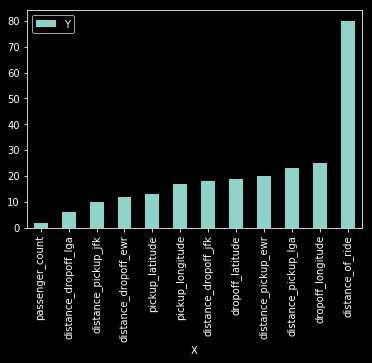

In [322]:
fscores = pd.DataFrame({'X': list(model.get_fscore().keys()), 'Y': list(model.get_fscore().values())})
fscores.sort_values(by='Y').plot.bar(x='X')

## Appendix

In [171]:
# Traffic Congestion Statistics
IFrame(CNG_PATH, width=960, height=1000)

In [ ]:
# Seasonal Adjustment Factors
IFrame(SAF_PATH, width=960, height=1000)